In [2]:
import glob
import os
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import CRS

import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import rasterio.mask
import rioxarray as rxr
import xarray as xr
from pyproj import Proj

from preprocessing_utils import *

%load_ext autoreload
%autoreload 2

### Import data sets

In [3]:
# Import Beas and Sutlej shapefiles
beas_shp = '/Users/marron31/Google Drive/PhD/gis/exports/beas_watershed.shp'
sutlej_shp = '/Users/marron31/Google Drive/PhD/gis/exports/sutlej_watershed.shp'

beas = gpd.read_file(beas_shp)
sutlej = gpd.read_file(sutlej_shp)

beas_wgs84 = beas.to_crs("EPSG:4326")
sutlej_wgs84 = sutlej.to_crs("EPSG:4326")

### Mosaic SRTM tiles

In [4]:
dirpath = r'/Users/marron31/Google Drive/PhD/srtm/'
search_criteria = '*hgt' 
mosaic_fp = r'/Users/marron31/Google Drive/PhD/srtm/mosaic.tif'

In [5]:
mosaic_tiles(dirpath, search_criteria, mosaic_fp)

### Mask DEM

In [6]:
catchments_wgs84 = beas_wgs84.append(sutlej_wgs84)

In [477]:
mask_raster(in_raster_path = r'/Users/marron31/Google Drive/PhD/srtm/mosaic.tif',
           out_raster_path = r'/Users/marron31/Google Drive/PhD/srtm/mosaic_masked_beas.tif',
           mask = beas_wgs84)

mask_raster(in_raster_path = r'/Users/marron31/Google Drive/PhD/srtm/mosaic.tif',
           out_raster_path = r'/Users/marron31/Google Drive/PhD/srtm/mosaic_masked_sutlej.tif',
           mask = sutlej_wgs84)

### Reproject

In [12]:
dem_rio = rxr.open_rasterio(out_fp)
dem_rio_lcc = dem_rio.rio.reproject(beas.crs)

print(dem_rio_lcc.rio.crs)

In [7]:
out_fp_lcc = r'/Users/marron31/Google Drive/PhD/srtm/mosaic_lcc.tif'

In [27]:
dem_rio_lcc.rio.to_raster(out_fp_lcc)

In [38]:
dem_rio_masked = rxr.open_rasterio(out_fp_masked, masked=True)
dem_rio_masked_lcc = dem_rio_masked.rio.reproject(beas.crs)

In [11]:
out_fp_masked_lcc = r'/Users/marron31/Google Drive/PhD/srtm/mosaic_masked_lcc.tif'


In [ ]:
dem_rio_masked_lcc.rio.to_raster(out_fp_masked_lcc)

### Plot on a map

In [12]:
# Import dem mosaic and masked dem
#dem = rasterio.open(out_fp)
#dem_masked = rasterio.open(out_fp_masked)
dem_lcc = rasterio.open(out_fp_lcc)
dem_masked_lcc = rasterio.open(out_fp_masked_lcc)

No handles with labels found to put in legend.


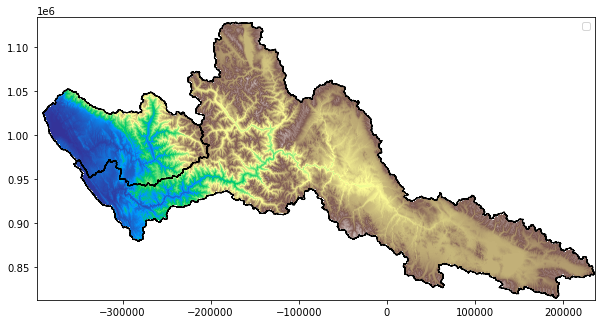

CPU times: user 14.6 s, sys: 5.33 s, total: 19.9 s
Wall time: 20.5 s


In [16]:
%%time
# Plot masked dem and catchment boundaries
fig, ax = plt.subplots(figsize=(10,10))
show(dem_masked_lcc, cmap='terrain', ax=ax)
beas.plot(ax=ax, facecolor='None', edgecolor='black', lw=1)
sutlej.plot(ax=ax, facecolor='None', edgecolor='black', lw=1)
plt.show()

### Coarsen DEM to match WRF grid

In [101]:
dem_rio_masked_lcc_coarse = dem_rio_masked_lcc.interp_like(ds_rename)
dem_rio_lcc_coarse = dem_rio_lcc.interp_like(ds_rename)

<AxesSubplot:title={'center':'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

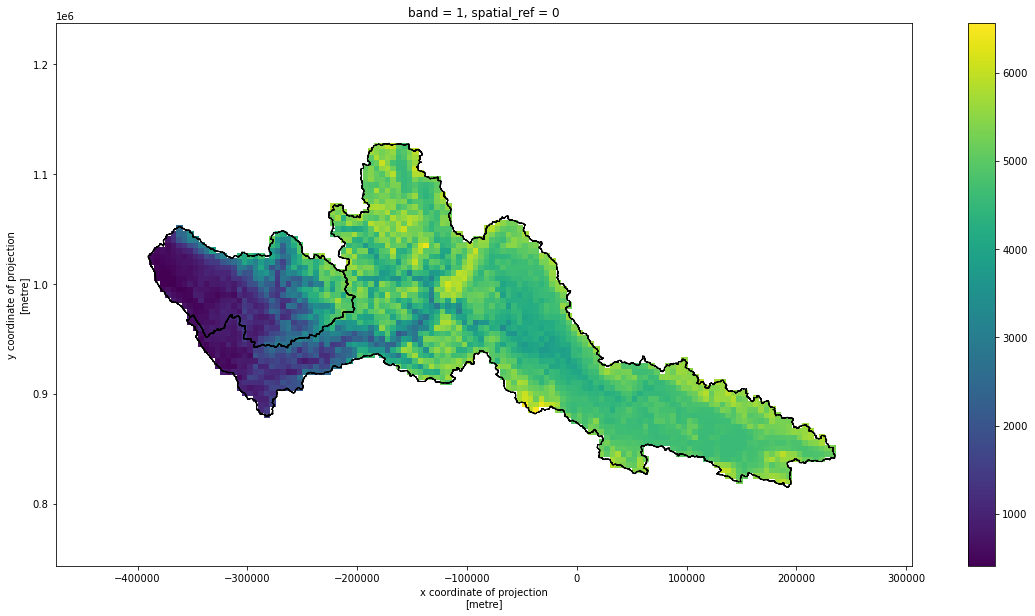

In [106]:
fig,ax = plt.subplots(figsize=(20,10))
dem_rio_masked_lcc_coarse.plot(ax=ax)
beas.plot(ax=ax, facecolor='None', edgecolor='black', lw=1)
sutlej.plot(ax=ax, facecolor='None', edgecolor='black', lw=1)
#dem_rio_lcc_coarse.plot(ax=ax)

In [61]:
wrf_path = '../../PhD/data/wrf/precipitation.nc'
ds = xr.open_dataset(wrf_path)

In [91]:
ds_rename = ds.rename({
    "projection_y_coordinate":"y",
    "projection_x_coordinate":"x"
})

In [151]:
save_path = '../../PhD/data/SUSHIWAT/srtm/srtm_marked_coarsened.nc'
dem_rio_masked_lcc_coarse.to_dataset(name='z').to_netcdf(save_path)

In [150]:
save_path = '../../PhD/data/SUSHIWAT/srtm/srtm_coarsened.nc'
dem_rio_lcc_coarse.to_dataset(name='z').to_netcdf(save_path)

In [152]:
srtm_ds = xr.open_dataset(save_path)

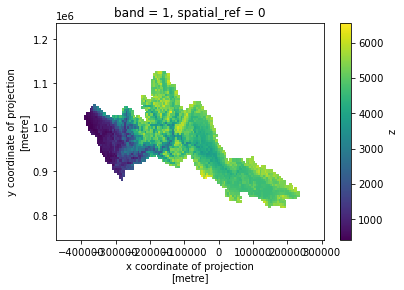

In [153]:
srtm_ds.z.plot()

### ERA 5 winds

In [220]:
path = r'../data/SUSHIWAT/ERA5/74E-84E_28N-35N/u/*.nc'
era5_u = xr.open_mfdataset(path).load()

path = r'../data/SUSHIWAT/ERA5/74E-84E_28N-35N/v/*.nc'
era5_v = xr.open_mfdataset(path).load()

In [379]:
era5_u_rename = era5_u.rename({
    "latitude":"y",
    "longitude":"x"
})

era5_v_rename = era5_v.rename({
    "latitude":"y",
    "longitude":"x"
})

In [380]:
era5_u_rename.rio.write_crs("epsg:4326", inplace=True)
era5_u_reprojected = era5_u_rename.u.rio.reproject_match(ds_rename.model_precipitation)

In [382]:
era5_v_rename.rio.write_crs("epsg:4326", inplace=True)
era5_v_reprojected = era5_v_rename.v.rio.reproject_match(ds_rename.model_precipitation)

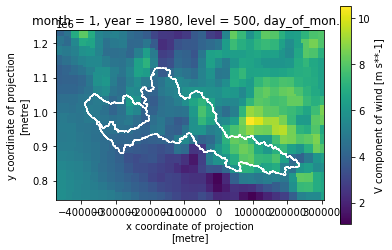

In [383]:
fig, ax = plt.subplots()
era5_v_reprojected.isel(time=10).plot(ax=ax)
beas.plot(ax=ax, facecolor='None',edgecolor='white')
sutlej.plot(ax=ax, facecolor='None', edgecolor='white')
plt.show()

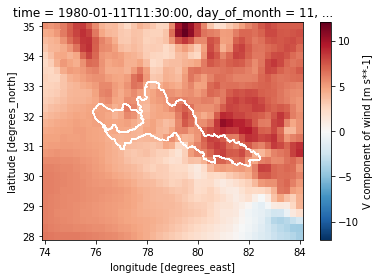

In [384]:
fig, ax = plt.subplots()
era5_v_rename.v.isel(time=10).plot(ax=ax)
# srtm_ds.z.plot(ax=ax)
beas_wgs84.plot(ax=ax, facecolor='None',edgecolor='white')
sutlej_wgs84.plot(ax=ax, facecolor='None',edgecolor='white')

plt.show()

In [277]:
ds_rename_wgs84 = ds_rename.model_precipitation.drop(['XLAT','XLONG']).rio.reproject("epsg:4326")

In [281]:
ds_rename_wgs84_dropepd = ds_rename_wgs84.where(ds_rename_wgs84 > -9999, drop=True)

In [244]:
wgs84 = Proj(proj='latlong', datum='WGS84') # Define WGS84 CRS 

# Define parameters for LCC CRS (based on WRF model configuration used in Bannister et al. 2019)
latitude_of_projection_origin = 23
longitude_of_central_meridian = 80
standard_parallel_1 = 30
standard_parallel_2 = 30
# false_easting = 79.10629
# false_northing = 31.888275

lcc = Proj(proj='lcc', 
           lat_1=standard_parallel_1,
           lat_2=standard_parallel_2,
           #ellps='WGS84',
           lat_0=latitude_of_projection_origin, 
           lon_0=longitude_of_central_meridian, 
           #x_0=false_easting, 
           #y_0=false_northing,
           a=6370000, 
           b=6370000
          )

#transformer = Transformer.from_proj(proj_from=lcc, proj_to=wgs84)

In [431]:
srtm_reprojected_masked = dem_rio_masked.rio.reproject_match(ds_rename, resampling=Resampling.average)

In [396]:
srtm_reprojected = dem_rio.rio.reproject_match(ds_rename, resampling=Resampling.average)

In [397]:
srtm_reprojected = srtm_reprojected.where(srtm_reprojected>0, drop=False)

In [500]:
srtm_beas = rxr.open_rasterio(filename=r'/Users/marron31/Google Drive/PhD/srtm/mosaic_masked_beas.tif',
                                          masked=True)

srtm_reprojected_beas = srtm_beas.rio.reproject_match(ds_rename, resampling=Resampling.average)

srtm_reprojected_beas = srtm_reprojected_beas.where(srtm_reprojected_beas>-999, drop=False)

ds = srtm_reprojected_beas.to_dataset(name='z')

save_path = '../../PhD/data/SUSHIWAT/ready/srtm_reprojected_beas.nc'

ds.to_netcdf(save_path)

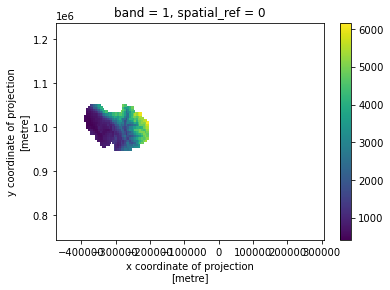

In [498]:
srtm_reprojected_beas.plot()

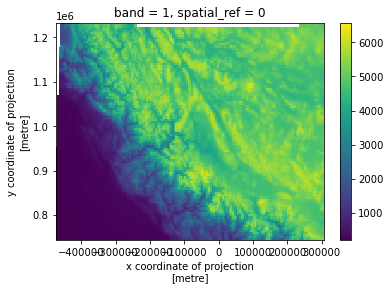

In [430]:
srtm_reprojected.where(srtm_ds.z > -999, drop=True).plot()

In [400]:
srtm_ds = srtm_reprojected.to_dataset(name='z')

In [433]:
srtm_ds_masked = srtm_reprojected_masked.to_dataset(name='z')

In [401]:
save_path = '../../PhD/data/SUSHIWAT/ready/srtm_reprojected.nc'
srtm_ds.to_netcdf(save_path)

In [434]:
save_path = '../../PhD/data/SUSHIWAT/ready/srtm_reprojected_masked.nc'
srtm_ds_masked.to_netcdf(save_path)

In [371]:
save_path = '../../PhD/data/SUSHIWAT/ready/era5_u_reprojected.nc'
era5_u_reprojected.to_netcdf(save_path)

In [385]:
save_path = '../../PhD/data/SUSHIWAT/ready/era5_v_reprojected.nc'
era5_v_reprojected.to_netcdf(save_path)

In [425]:
save_path = '../../PhD/data/SUSHIWAT/ready/wrf.nc'
ds.to_netcdf(save_path)